Решить задачу регрессии. Получить максимальную метрику качества (R2, RMSE). 
Не забываем про введение и выводы.  Дедлайн 23.11

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

df = pd.read_csv("Walmart.csv")

df

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,05-02-2010,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,19-02-2010,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,26-02-2010,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,05-03-2010,1554806.68,0,46.50,2.625,211.350143,8.106
...,...,...,...,...,...,...,...,...
6430,45,28-09-2012,713173.95,0,64.88,3.997,192.013558,8.684
6431,45,05-10-2012,733455.07,0,64.89,3.985,192.170412,8.667
6432,45,12-10-2012,734464.36,0,54.47,4.000,192.327265,8.667
6433,45,19-10-2012,718125.53,0,56.47,3.969,192.330854,8.667


In [2]:
#исходя и данных, пропуски(значения NAN)в данном датасете отсутствуют
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         6435 non-null   int64  
 1   Date          6435 non-null   object 
 2   Weekly_Sales  6435 non-null   float64
 3   Holiday_Flag  6435 non-null   int64  
 4   Temperature   6435 non-null   float64
 5   Fuel_Price    6435 non-null   float64
 6   CPI           6435 non-null   float64
 7   Unemployment  6435 non-null   float64
dtypes: float64(5), int64(2), object(1)
memory usage: 402.3+ KB


In [3]:
#проверим столбцы датафрейиа на наличие нулей
for col in df.columns:
    pct_missing = np.mean(df[col] == 0)
    print('{} - {}%'.format(col, round(pct_missing*100)))

Store - 0%
Date - 0%
Weekly_Sales - 0%
Holiday_Flag - 93%
Temperature - 0%
Fuel_Price - 0%
CPI - 0%
Unemployment - 0%


Таким образом, видим, что по столбцам, где нули считадлись бы некорректным значением, таких данных нет, т.е. приходим к выводу, что в данном датасете отсутствуют пропуски данных 

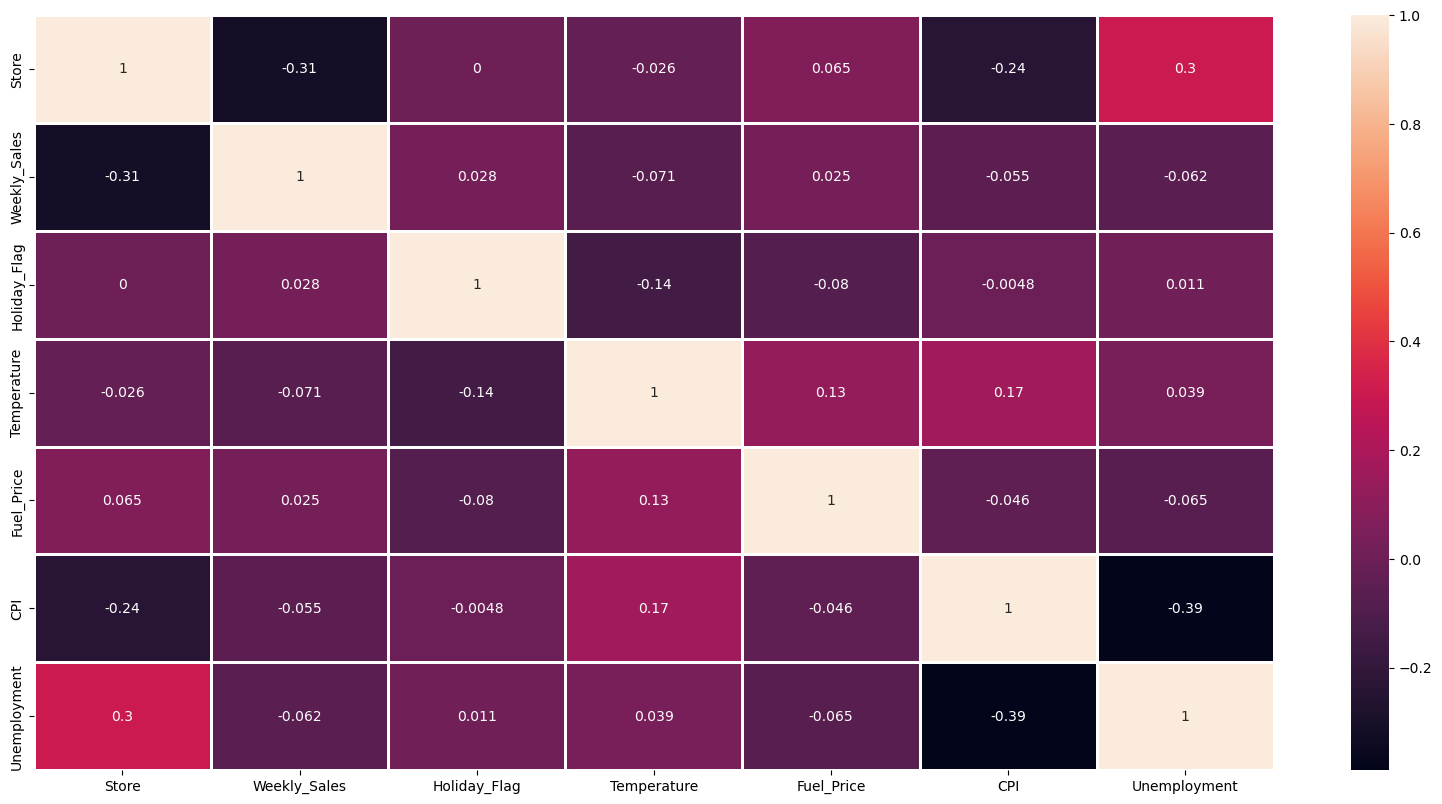

In [4]:
corr_matrix = df.corr()

plt.figure(figsize=(20,10), dpi=100)
corr = df.corr(method='spearman')
sns.heatmap(corr, annot=True, linewidths=1);

Исходя из матрицы корреляции видоим достаточно высокую зависисимость продаж от самого магазина. Так же есть небольшая зависимость от дня праздника. Поскольку в датафрейме так же есть столбец даты, будем анализировать его отдельно.

Определим кодичество уникальных дат во всем всем датафрейме

In [5]:
unique_dates = df.Date.unique()

print(len(unique_dates))

143


Т.е. в данном случае у нас отражены данные по одним и тем же дата, но в разных магазинах. Исходя из этого предсказывать продажи будем исходя из гипотезы, что каждая дата является отдельным категориальным значением.

In [6]:
data_set = df.copy(deep = True)

data_set[('Date')] = data_set[('Date')].values.astype("str")

#Поскольку стобец Weekly_Sales нам необходимо предсказать, вынесем его в отдельный датафрейм и удалим из основного датафоейма

Y = data_set["Weekly_Sales"]

data_set = data_set.drop(['Weekly_Sales'], axis=1)

data_set = pd.concat([data_set,
                pd.get_dummies (data_set.Date, prefix = 'Date')], axis=1)

data_set.drop (['Date'], axis = 1, inplace=True)

In [7]:
#разобьем получившийся датасет на тестовуб и тренировочную выборки
X_train, X_test, y_train, y_test = train_test_split(data_set,Y,random_state=42, train_size=0.3)

решим задачу регрессии с помошью: 
- метода наименьших квадлратов(linear regression)
- метода случайных лесов
- полиномиальной регресиии

## Обучим модель Линейной регрессии:

In [8]:
lr = LinearRegression(n_jobs=-1)
lr.fit(X_train, y_train)

lr_predictions = lr.predict(X_test)

Text(0, 0.5, 'Предсказанная сумма')

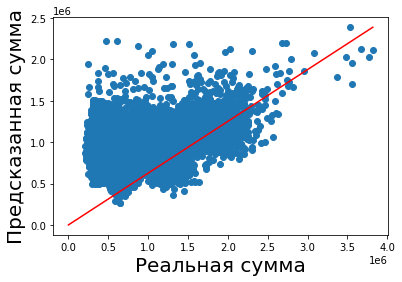

In [9]:
plt.scatter(y_test, lr_predictions) # точки, соответствущие парам настоящее значение - прогноз
plt.plot([0, max(y_test)], [0, max(lr_predictions)], color = 'red')  # прямая, на которой предсказаные и реальные значения совпадают
plt.xlabel('Реальная сумма', fontsize=20)
plt.ylabel('Предсказанная сумма', fontsize=20)

## Метрики качества для линейной регрессии

In [10]:
lr_mae = mean_absolute_error(y_test, lr_predictions)
print("MAE - {}\n".format(lr_mae))
lr_mse = mean_squared_error(y_test, lr_predictions)
print("MSE - {}\n".format(lr_mse**0.5))
lr_r2s = r2_score(y_test, lr_predictions)
print("lr2 - {}\n".format(lr_r2s))

MAE - 436300.8365593785

MSE - 528556.8005072405

lr2 - 0.11121149139182462



## Обучим модель полиномиальной регрессии:

In [11]:
pr = make_pipeline(PolynomialFeatures(), LinearRegression(n_jobs=-1))
pr.fit(X_train, y_train)

pr_predictions = pr.predict(X_test)

Text(0, 0.5, 'Предсказанная сумма')

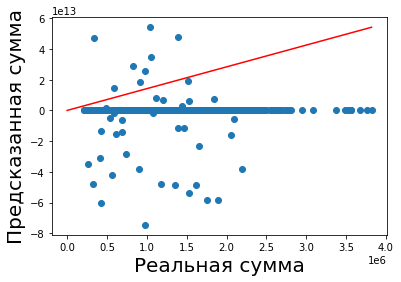

In [12]:
plt.scatter(y_test, pr_predictions) # точки, соответствущие парам настоящее значение - прогноз
plt.plot([0, max(y_test)], [0, max(pr_predictions)], color = 'red')  # прямая, на которой предсказаные и реальные значения совпадают
plt.xlabel('Реальная сумма', fontsize=20)
plt.ylabel('Предсказанная сумма', fontsize=20)

## Метрики качества для полиномиальной регрессии

In [13]:
pr_mae = mean_absolute_error(y_test, pr_predictions)
print("MAE - {}\n".format(pr_mae))
pr_mse = mean_squared_error(y_test, pr_predictions)
print("MSE - {}\n".format(pr_mse**0.5))
pr_r2s = r2_score(y_test, pr_predictions)
print("lr2 - {}\n".format(pr_r2s))

MAE - 257615205532.0591

MSE - 3298102241478.2896

lr2 - -34605356720161.1



## Метод случайных лесов

In [14]:
rf = RandomForestRegressor(random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
rf_predictions = rf.predict(X_test)

Text(0, 0.5, 'Предсказанная сумма')

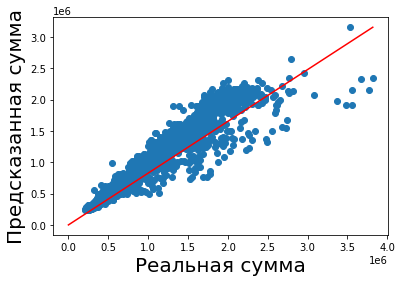

In [15]:
plt.scatter(y_test, rf_predictions) # точки, соответствущие парам настоящее значение - прогноз
plt.plot([0, max(y_test)], [0, max(rf_predictions)], color = 'red')  # прямая, на которой предсказаные и реальные значения совпадают
plt.xlabel('Реальная сумма', fontsize=20)
plt.ylabel('Предсказанная сумма', fontsize=20)

## Метрики качества для случайного леса

In [16]:
rf_mae = mean_absolute_error(y_test, rf_predictions)
print("MAE - {}\n".format(rf_mae))
rf_mse = mean_squared_error(y_test, rf_predictions)
print("MSE - {}\n".format(rf_mse**0.5))
rf_r2s = r2_score(y_test, rf_predictions)
print("lr2 - {}\n".format(rf_r2s))

MAE - 77209.72754952275

MSE - 148803.06951967647

lr2 - 0.9295568316850191



## Выводы:

- Для предсказания продаж были построены модели RandomForest, LinearRegression и PolynomialRegression. Наилучшие метрики показала модель RandomForest
- Исходя из матрицы корреляции наибольшее влияение на еженелельные продажи оказывает сам магазин(Store), другие же показатели(включая наличие праздничного дня на неделе) мало влияет на результаты продаж